In [ ]:
import os

len(os.listdir('/data/xp/train_test_data/1. T2D-CAD-RJ/match_ms2'))

In [1]:
import os
import numpy as np
from spectra_match.matcher import MzmlMatcher

dir = '/data/xp/data/astral_20231016_300ngPlasmaSample/merge'

files = [os.path.join(dir, file) for file in os.listdir(dir) if file.endswith('.npy')]

label_path = '/data/xp/label/astral_20231016_300ngPlasmaSample/train_identification.npy'

identification_label = np.load(label_path, allow_pickle=True).item()

matcher = MzmlMatcher(
    data_name='astral_20231016_300ngPlasmaSample',
    save_dir_path='/data/xp/train_test_data',
    library_path='/data/xp/library/AD8_Trypsin_Astral_directDIALibrary_Top6_Target_DecoyPsps23_SumNorm.npy',
    massspectrum_file_list=files,
    identify_labels=identification_label,
    quant_labels={},
    match_params_config={
        'num_workers': 5,
        'filter_ms2_num': 10,
        'peptide_peak_num': 6,
        'tol': 15,
        'match_ms2peak_num': 3
    },
    flag_params_config={
        'is_featuredIons': True
    }
)

files = matcher.file_name_seq

train_data, test_data = matcher.identification_train_test_data(files[0], 'penalty_MAE_peaksum')

所有目录创建完毕 用时 4.76837158203125e-05 秒
训练数据个数: 31194
测试数据个数: 41098
------------------------------------------------------------------------------------------------------------------------
20231016_300ngPlasmaSample_7p5min_100um-13cm_P2-81 处理完毕，用时 0.00 时 1.00 分 35.73 秒
------------------------------------------------------------------------------------------------------------------------


In [50]:
import numpy as np
import numpy.typing as npt

def peaksum(A: npt.NDArray, B: npt.NDArray):
    max_norm_B = B / np.max(B)
    scores = np.zeros((len(A), len(B)))
    for i in range(len(A)):
        for j in range(len(B)):
            scores[i, j] = np.sum(max_norm_B[j])
    return scores

def MAE_peaksum(A: npt.NDArray, B: npt.NDArray):
    peaksum_score = peaksum(A, B)
    penalty_MAE_score = MAE(A, B)
    return peaksum_score + penalty_MAE_score

def penalty_MAE_peaksum(A: npt.NDArray, B: npt.NDArray):
    peaksum_score = peaksum(A, B)
    penalty_MAE_score = penalty_MAE(A, B)
    return peaksum_score + penalty_MAE_score

def penalty_MAE(A: npt.NDArray, B: npt.NDArray):
    scores = np.zeros((len(A), len(B)))
    for i in range(len(A)):
        for j in range(len(B)):
            a, b = A[i], B[j]
            # 某些母离子在库中的峰少于规定的峰数量，因此会进行补全
            # 对于补全的峰，不需要进行惩罚项处理
            non_empty_indices = np.where(a != 0)[0]
            a = a[non_empty_indices]
            b = b[non_empty_indices]
            b = b / np.sum(b)
            b[b == 0] = 1
            scores[i, j] = np.sum(np.abs(a - b))
    return -scores

def cosine(A: npt.NDArray, B: npt.NDArray):
    norm_A = np.linalg.norm(A, axis=1, keepdims=True)
    norm_B = np.linalg.norm(B, axis=1, keepdims=True)
    norlize_A = A / norm_A
    norlize_B = B / norm_B
    return np.dot(norlize_A, norlize_B.T)

def MAE(A: npt.NDArray, B: npt.NDArray):
    sum_norm_B = B / np.sum(B, axis=1, keepdims=True)
    scores = np.zeros((len(A), len(B)))
    for i in range(len(A)):
        for j in range(len(B)):
            scores[i, j] = np.sum(np.abs(A[i] - sum_norm_B[j]))
    return -scores

from utils.io import read_dict_npy
score_distribution = []
data = read_dict_npy('/data/xp/train_test_data/astral_20231016_300ngPlasmaSample/filter_ms2/penalty_MAE_peaksum/20231016_300ngPlasmaSample_7p5min_100um-13cm_P1-44/collection.npy')
for _, metadata in data.items():
    spectrum = metadata['Spectrum']
    peaks = metadata['filter_ms2_metadata']['peaks']
    ref_intensity = spectrum[:, 1]
    ex_intensity = peaks[:, :, 1]
    scores = MAE_peaksum([ref_intensity], ex_intensity)[0]
    score_distribution.append(scores.flatten())
score_distribution = np.concatenate(score_distribution)

<Axes: ylabel='Count'>

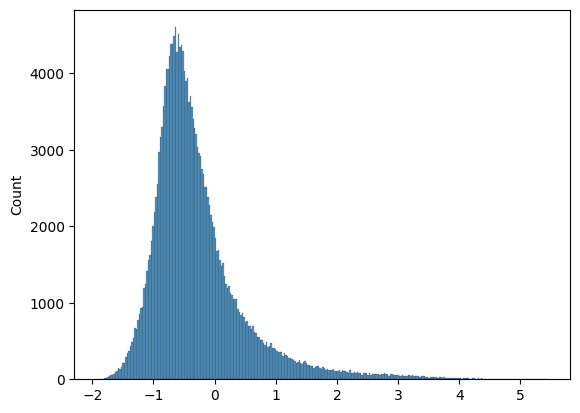

In [51]:
import seaborn as sns

sns.histplot(score_distribution)

In [ ]:
import numpy as np
np.load('/data/xp/train_test_data/astral_20231016_300ngPlasmaSample/')

In [ ]:
from library.library_generation import generate_target_deocy_library, NORM_SELECTION

astral_raw_library = '/data/xp/raw_library/AD8_Trypsin_Astral_directDIALibrary.tsv'
tims_raw_library = '/data/xp/raw_library/AD8_MeS_MN_AC_Brain_AcuteExercise_20240428.tsv'
save_dir = '/data/xp/library'

decoy_distance = 23
tims = generate_target_deocy_library(tims_raw_library, save_dir, decoy_distance, NORM_SELECTION.SUM_NORM)
astral = generate_target_deocy_library(astral_raw_library, save_dir, decoy_distance, NORM_SELECTION.SUM_NORM)

In [ ]:
import numpy as np

data1 = np.load('/data/xp/library/AD8_MeS_MN_AC_Brain_AcuteExercise_20240428_Top6_Target_DecoyPsps23_SumNorm.npy', allow_pickle=True).item()
data2 = np.load('/data/xp/library/AD8_Trypsin_Astral_directDIALibrary_Top6_Target_DecoyPsps23_SumNorm.npy', allow_pickle=True).item()
len(data1.keys() & data2.keys()), len(data1), len(data2)

In [ ]:
data2[('_TRWYSMK_', 2)]

In [ ]:
data1[('_AAC[Carbamidomethyl (C)]LLPKLDELRDEGK_', 3)]

In [ ]:
np.load('/data/xp/library/AD8_Trypsin_Astral_directDIALibrary_Top6_Decoy_Psps100_SumNorm.npy', allow_pickle=True).item()

In [ ]:
data1[('_AAAATGTIFTFR_', 2)]['Spectrum'], data2[('_AAAATGTIFTFR_', 2)]['Spectrum']

In [ ]:
size = os.path.getsize('/data/xp/library/AD8_MeS_MN_AC_Brain_AcuteExercise_20240428_Top6_SumNorm.npy')
GB, size = divmod(size, 1024 ** 3)
MB, size = divmod(size, 1024 ** 2)
KB, size = divmod(size, 1024)
print('文件占用 {:1f} GB {:1f} MB {:1f} KB'.format(GB, MB, KB))

In [ ]:
import numpy as np

filter_ms2_num = 10
peptide_peak_num = 6

dtype = np.dtype([('matched_ms2', np.float32, (filter_ms2_num, peptide_peak_num, 2)), ('label', np.int16), ('info', object)])
x = np.array([], dtype=dtype)
x = np.append(
    x, 
    np.array([(np.random.rand(filter_ms2_num, peptide_peak_num, 2), np.random.randint(0, 2), ('1', (2, 3))),
    (np.random.rand(filter_ms2_num, peptide_peak_num, 2), np.random.randint(0, 2), ('1', (2, 3)))], dtype=dtype)
)

In [29]:
import numpy as np

filter_ms2_num = 10
peptide_peak_num = 6

dtype = np.dtype([('matched_ms2', np.float32, (filter_ms2_num, peptide_peak_num, 2)), ('label', np.int16), ('info', object)])
y = []
for j in range(10):
    x = []
    for i in range(1, j + 2):
        data = np.array([(np.random.rand(filter_ms2_num, peptide_peak_num, 2), np.random.randint(0, 2), ('1', (2, 3)))], dtype=dtype)
        x.append(data)
    x = np.concatenate(x, axis=0)
    y.append(x)

In [5]:
import numpy as np

path = '/data/xp/train_test_data/astral_20231016_300ngPlasmaSample/train/identification/penalty_MAE_peaksum/collection.npy'

data = np.load(path, allow_pickle=True)

In [6]:
data['Info']

array([('20231016_300ngPlasmaSample_7p5min_100um-13cm_P2-81', (406.43463521656, 408.43554478344), ('DECOY-_TKFETEQALR_', 3)),
       ('20231016_300ngPlasmaSample_7p5min_100um-13cm_P2-81', (478.46737521656, 480.46828478343997), ('DECOY-_TNHFTIPK_', 2)),
       ('20231016_300ngPlasmaSample_7p5min_100um-13cm_P2-81', (788.60837521656, 790.60928478344), ('_ADVLTTGAGNPVGDKLNVITVGPR_', 3)),
       ...,
       ('20231016_300ngPlasmaSample_7p5min_100um-13cm_P2-87', (978.69473521656, 980.69564478344), ('DECOY-_IQKLESDVSAQMEYC[Carbamidomethyl (C)]R_', 2)),
       ('20231016_300ngPlasmaSample_7p5min_100um-13cm_P2-87', (978.69473521656, 980.69564478344), ('DECOY-_AAAQLLQSQAQQSGAQQTK_', 2)),
       ('20231016_300ngPlasmaSample_7p5min_100um-13cm_P2-87', (972.69198521656, 974.69289478344), ('DECOY-_VNPTVFFDIAVDGEPLGR_', 2))],
      dtype=object)

In [2]:
from data_utils.dataset import MzmlDataset

dataset = MzmlDataset(data)

In [4]:
x, info, y = dataset[0]

In [2]:
import os

os.path.getsize('/data/xp/model/astral_20231016_300ngPlasmaSample/identification.ckpt')

94511

In [4]:
import numpy as np
from scipy.stats import pearsonr
from scipy.interpolate import interp1d

# 假设我们有六个碎片离子的洗脱曲线数据，包含零值
fragment_ions = {
    'fragment1': [10, 12, 0, 14, 10, 8],
    'fragment2': [9, 0, 13, 14, 11, 9],
    'fragment3': [11, 13, 16, 0, 12, 10],
    'fragment4': [8, 10, 0, 13, 9, 7],
    'fragment5': [10, 12, 17, 16, 0, 9],
    'fragment6': [0, 11, 14, 13, 10, 8]
}

def fill_zeros(data):
    # 使用线性插值法补全数据
    x = np.arange(len(data))
    non_zero_indices = x[data != 0]
    non_zero_values = data[data != 0]
    interpolator = interp1d(non_zero_indices, non_zero_values, kind='linear', fill_value="extrapolate")
    return interpolator(x)

# 补全每个碎片离子的信号强度数据
for ion in fragment_ions:
    fragment_ions[ion] = fill_zeros(np.array(fragment_ions[ion]))

# 计算皮尔森相关系数之和并选择最佳碎片离子
best_fragment = None
best_score = -np.inf

for candidate in fragment_ions:
    others = [ion for ion in fragment_ions if ion != candidate]
    score = sum(pearsonr(fragment_ions[candidate], fragment_ions[other])[0] for other in others)
    
    if score > best_score:
        best_score = score
        best_fragment = candidate

print(f"最佳碎片离子: {best_fragment}，皮尔森相关系数之和: {best_score}")


最佳碎片离子: fragment6，皮尔森相关系数之和: 4.742583037033388


In [4]:
import numpy as np

SpectraLibrary = np.load('/data/xp/library/AD8_MeS_MN_AC_Brain_AcuteExercise_20240428_Top6_Target_DecoyPsps23_SumNorm.npy', allow_pickle=True).item()

charges = set(np.array(list(SpectraLibrary.keys()))[:, 1].astype(int))

dtype = np.dtype([('precursor_mz', np.float64), ('precursor', object)])

for charge in charges:
    LibraryDividedByCharge = {
        key: value for key, value in SpectraLibrary.items() if key[1] == charge
    }
    precursors = np.concatenate([
        np.array([(
            value['PrecursorMz'],
            key
        )], dtype=dtype)
        for key, value in LibraryDividedByCharge.items()
    ], axis=0)
    for i, (mz, precursor) in enumerate(precursors):
        pass

In [11]:
import numpy as np

dt = np.dtype([('a', np.float32, (1, 5))])

x = np.array([1, 2, 3, 4, 5])
print(x)

print(x.shape)

y = np.array([x], dtype=dt)

[1 2 3 4 5]
(5,)


In [1]:
import numpy as np

data = np.load('/data/xp/train_test_data/astral_20231016_300ngPlasmaSample/train/identification/penalty_MAE_peaksum/collection.npy', allow_pickle=True)

In [25]:
import torch

s = torch.tensor([[1,2 , 3],
                  [2,3 , 4]])
torch.max(s, dim=0)[0]

tensor([2, 3, 4])

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def ppm(ex_ms2, spectrum):
    exms2_mz = ex_ms2[:, :, 0]
    s_mz = spectrum[:, :, 0]
    
    mz = np.full_like(exms2_mz, -1)
    empty_indices = (exms2_mz == 0).nonzero()
    non_empty_indices = (exms2_mz > 0).nonzero()

    mz[non_empty_indices] = exms2_mz[non_empty_indices]

    ppm_values = (s_mz - mz) / (mz * 1e-6)

    ppm_values[empty_indices] = 100

    return ppm_values

def plot_ppm_distribution(path: str):
    data = np.load(path, allow_pickle=True)

    ppm_distribution = {
        'target': [],
        'decoy': []
    }


    for ex_ms2, spectrum, label in zip(data['Ex_ms2'], data['Spectrum'], data['Label']):
        type_ = 'target'
        if not label:
            type_ = 'decoy'
        ppm_ = ppm(ex_ms2, spectrum)
        ppm_distribution[type_].extend(list(ppm_[ppm_ != 100].flatten()))

    fig, ax = plt.subplots(1, 1, dpi=300, figsize=(5, 2.7))
    sns.histplot(ppm_distribution['target'], bins=300, label='target', ax=ax)
    sns.histplot(ppm_distribution['decoy'], bins=300, label='decoy', ax=ax)
    ax.legend(loc='upper center', ncol=2, frameon=False)

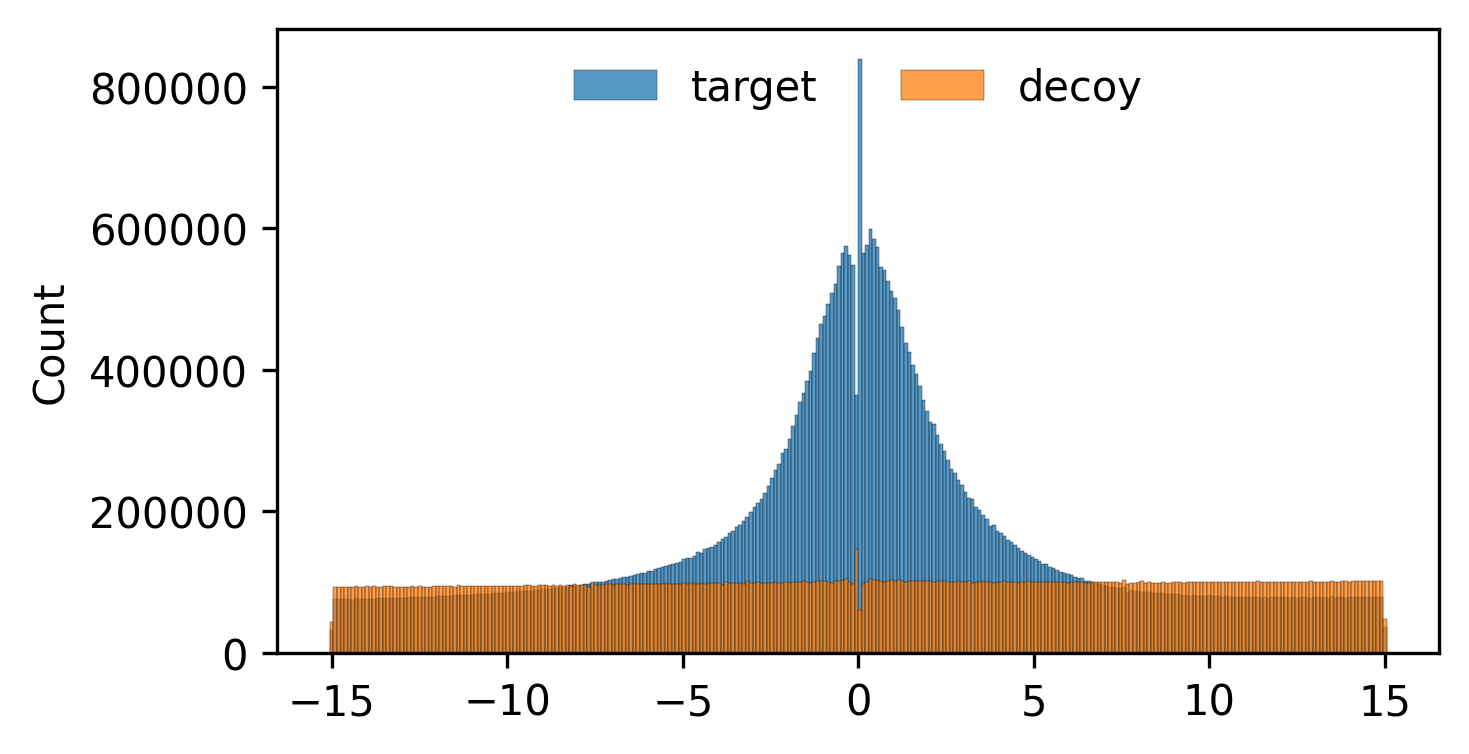

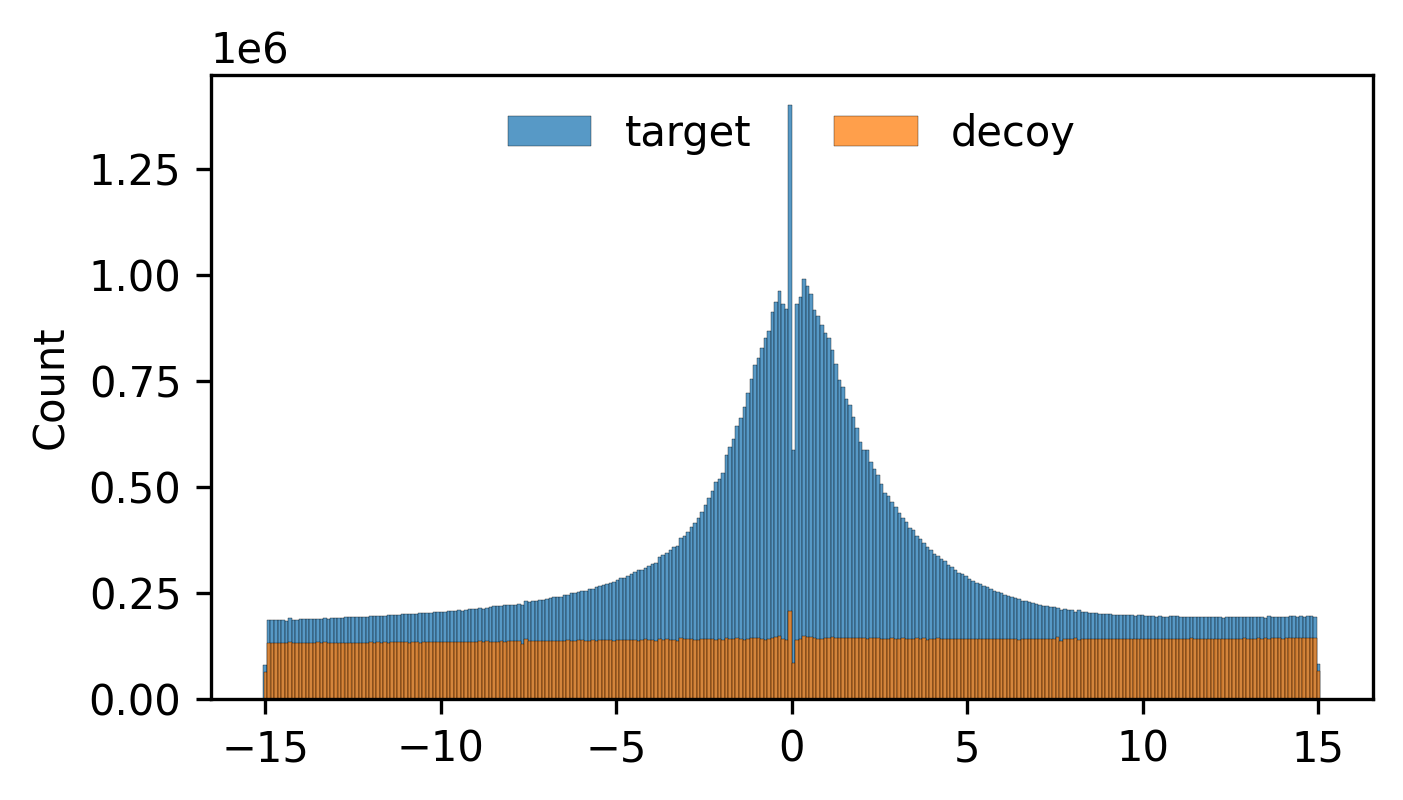

In [8]:
train_path = '/data/xp/train_test_data/astral_20231016_300ngPlasmaSample/train/identification/penalty_MAE_peaksum/collection.npy'
test_path = '/data/xp/train_test_data/astral_20231016_300ngPlasmaSample/test/identification/penalty_MAE_peaksum/collection.npy'
plot_ppm_distribution(train_path)
plot_ppm_distribution(test_path)

In [36]:
import numpy as np

def calculate_xic_correlation(ex_ms2, mask):
    xic = ex_ms2[~mask, :, 1].T
    analysis_indices = np.any(xic > 0, axis=1).nonzero()[0]
    empty_indices = np.all(xic == 0, axis=1).nonzero()[0]
    xic = xic[analysis_indices]
    
    if xic.shape[1] == 1:
        return np.zeros(ex_ms2.shape[1])

    coeff = np.corrcoef(xic)
    index = np.sum(coeff, axis=1).argmax()
    corr_vec = coeff[index]
    for index in empty_indices:
        corr_vec = np.insert(corr_vec, index, 0)
    
    return corr_vec

path = '/data/xp/train_test_data/astral_20231016_300ngPlasmaSample/test/identification/penalty_MAE_peaksum/collection.npy'

data = np.load(path, allow_pickle=True)
label = []
for info in data['Info']:
    if 'DECOY-' in info[2][0]:
        label.append(0)
    else:
        label.append(1)

label = np.array(label)

target = data[label == 1]
decoy = data[label == 0]

coeffs = {
    'target': [],
    'decoy': []
}

correlation = calculate_xic_correlation(target['Ex_ms2'][5], target['Mask'][5])
print(correlation)
print(target['Ex_ms2'][5][~target['Mask'][5], :, 1])

def ppm(ex_ms2, spectrum):
    exms2_mz = ex_ms2[:, :, 0]
    s_mz = spectrum[:, :, 0]
    
    mz = np.full_like(exms2_mz, -1)
    empty_indices = (exms2_mz == 0).nonzero()
    non_empty_indices = (exms2_mz > 0).nonzero()

    mz[non_empty_indices] = exms2_mz[non_empty_indices]

    ppm_values = np.abs((s_mz - mz) / (mz * 1e-6))

    ppm_values[empty_indices] = -1

    return ppm_values

[0.99999483 0.99986696 0.99998358 1.         0.99997275 0.99989557]
[[7.4520350e+05 1.5980591e+05 2.8191903e+05 4.1303256e+05 3.3883509e+05
  1.6949588e+05]
 [5.3510680e+06 9.9361700e+05 1.8974789e+06 2.9005405e+06 2.4848440e+06
  1.3194805e+06]
 [1.0275864e+04 5.5357441e+03 3.5097217e+03 6.7519009e+03 5.4888462e+03
  2.7081221e+03]
 [2.7831289e+04 6.8780869e+03 1.2535616e+04 1.4669986e+04 1.4913439e+04
  5.3763369e+03]
 [2.4651227e+04 1.4827085e+04 1.1066131e+04 1.2566414e+04 1.7103977e+04
  6.5665337e+03]
 [1.5236575e+04 8.4564121e+03 1.1255007e+04 1.1822070e+04 6.1140752e+03
  6.8868237e+03]]


In [59]:
ex_ms2, spectrum, mask, featured_ion, xic_corr, ppm, info = target['Ex_ms2'], target['Spectrum'], target['Mask'], target['Featured_ion'], target['Xic_corr'], target['Ppm'], target['Info']

In [48]:
np.set_printoptions(precision=2)

In [66]:
ex_ms2[10], ex_ms2[10][:, :, 1], spectrum[10][:, :, 1], mask[10], featured_ion[10], xic_corr[10], ppm[10], info[10]

(array([[[  509.26,  1748.73],
         [    0.  ,     0.  ],
         [  732.38,   834.43],
         [  781.91,  6183.99],
         [    0.  ,     0.  ],
         [    0.  ,     0.  ]],
 
        [[  509.25,  1550.36],
         [    0.  ,     0.  ],
         [    0.  ,     0.  ],
         [  781.91,  5445.28],
         [  838.45,   877.8 ],
         [    0.  ,     0.  ]],
 
        [[    0.  ,     0.  ],
         [  622.35,   878.58],
         [    0.  ,     0.  ],
         [  781.92, 79050.01],
         [  838.45,   410.01],
         [    0.  ,     0.  ]],
 
        [[  509.26,  5578.54],
         [  622.34,  2099.65],
         [    0.  ,     0.  ],
         [  781.91, 10003.59],
         [    0.  ,     0.  ],
         [    0.  ,     0.  ]],
 
        [[    0.  ,     0.  ],
         [    0.  ,     0.  ],
         [    0.  ,     0.  ],
         [  781.92,  7625.31],
         [  838.45,  1403.02],
         [  978.5 ,   742.86]],
 
        [[  509.25,  2232.79],
         [    0.  ,     

In [65]:
np.corrcoef(ex_ms2[10][:, :, 1].T)

array([[ 1.  ,  0.7 , -0.02, -0.41, -0.61, -0.32],
       [ 0.7 ,  1.  , -0.28,  0.25, -0.39, -0.44],
       [-0.02, -0.28,  1.  , -0.23, -0.38, -0.31],
       [-0.41,  0.25, -0.23,  1.  , -0.06, -0.29],
       [-0.61, -0.39, -0.38, -0.06,  1.  ,  0.43],
       [-0.32, -0.44, -0.31, -0.29,  0.43,  1.  ]])

In [1]:
import numpy as np

library_path = '/data/xp/library/AD8_Trypsin_Astral_directDIALibrary_Top6_Target_DecoyPsps23_SumNorm.npy'

library = np.load(library_path, allow_pickle=True).item()
library[('_IIVDELKQEVISTSSK_', 3)]

{'StrippedPeptide': 'IIVDELKQEVISTSSK',
 'PrecursorMz': 597.0032958984375,
 'iRT': 50.960293,
 'IonMobility': 0.85502815,
 'ProteinGroups': 'P63244',
 'Spectrum': array([[5.09256568e+02, 7.59770849e-02],
        [6.22340632e+02, 6.68438129e-02],
        [7.32383028e+02, 1.24033596e-01],
        [7.81917235e+02, 5.93409087e-01],
        [8.38459267e+02, 8.05837820e-02],
        [9.78510216e+02, 5.91526378e-02]]),
 'Fragment': array([['y', 5, 'noloss', 1],
        ['y', 6, 'noloss', 1],
        ['y', 13, 'noloss', 2],
        ['y', 14, 'noloss', 2],
        ['y', 15, 'noloss', 2],
        ['y', 9, 'noloss', 1]], dtype=object),
 'decoy': False}

In [84]:
import numpy as np
path = '/data/xp/train_test_data/astral_20231016_300ngPlasmaSample/filter_ms2/penalty_MAE_peaksum/20231016_300ngPlasmaSample_7p5min_100um-13cm_P1-44/collection.npy'
data = np.load(path, allow_pickle=True).item()

In [87]:
from scipy.stats import linregress

import numpy.typing as npt

def calculate_coeff(ref_intensity, experiment_intensity):
    return linregress(ref_intensity, experiment_intensity)[0]

def calculate_featured_ions_coeff(ref_intensity: npt.NDArray, featured_ions: npt.NDArray, experiment_intensity: npt.NDArray):
    matched_indices = experiment_intensity > 0
    featured_matched_indices = np.array(featured_ions, dtype=bool) & matched_indices
    coeff = 0
    penalty = np.sum(ref_intensity[~matched_indices])
    if np.sum(featured_matched_indices) == 0:
        return -1
    else:
        coeff = calculate_coeff(
            list(ref_intensity[featured_matched_indices]) + [penalty],
            list(experiment_intensity[featured_matched_indices]) + [0]
        )
    return coeff

def calculate_ex_ms2_featured_ions_coeff(experiment_ms2: npt.NDArray, ref_spectrum: npt.NDArray, featured_ions: npt.NDArray):
    experiment_intensity = experiment_ms2[:, :, 1]
    ref_intensity = ref_spectrum[:, 1]
    coeffs = []
    for ex_intensity in experiment_intensity:
        coeff = calculate_featured_ions_coeff(ref_intensity, featured_ions, ex_intensity)
        coeffs.append(coeff)
    return np.array(coeffs)

In [88]:
coeffs = []
for modified_peptide, metadata in data.items():
    spectrum = metadata['Spectrum']
    featured_ion = metadata['FeaturedIons']
    ex_ms2 = metadata['filter_ms2_metadata']['peaks']
    coeffs.append(calculate_ex_ms2_featured_ions_coeff(ex_ms2, spectrum, featured_ion))

In [89]:
coeffs

[array([-8.95626415e+03, -6.59945166e+04, -1.54892788e+04,  5.77084188e+01,
        -9.53306209e+02,  1.90627752e+02]),
 array([-37024.50702982,  -7215.67381418,  11936.11649688,  -4598.69782986,
         -3004.69709552,  -2379.12565139]),
 array([  -6115.8786523 ,   -5038.67486492,   -3502.46910879,
        -280235.83086519, -301276.59588162,   -2521.5655214 ]),
 array([-1598.35793444]),
 array([328686.40544494, 540658.07521402, 834332.45182866,  75050.92921216,
         53540.16014889,  40216.63171739]),
 array([ 15574.28091681, 266927.99332531,   6383.38611246,  -1441.48928254,
         -1437.03691851, -13627.4548684 ]),
 array([-329416.69135172,   -1528.41550381,   -1278.04044293]),
 array([26089.18969638,  7673.70139394,  -128.34330278,  2531.02060058,
        -2282.79436546]),
 array([ -5597.84059951, -11395.35955444,  37698.65034675,  -1086.16808078,
        -13572.87746717,  -5235.83642868]),
 array([ 19222.31173049, 296901.45382914,  77340.15386176,  45756.88536162,
         4

In [1]:
import numpy as np
from scipy.signal._savitzky_golay import savgol_filter

data = np.load('/data/xp/train_test_data/astral_20231016_300ngPlasmaSample/match_ms2/20231016_300ngPlasmaSample_7p5min_100um-13cm_P1-44/collection.npy', allow_pickle=True).item()

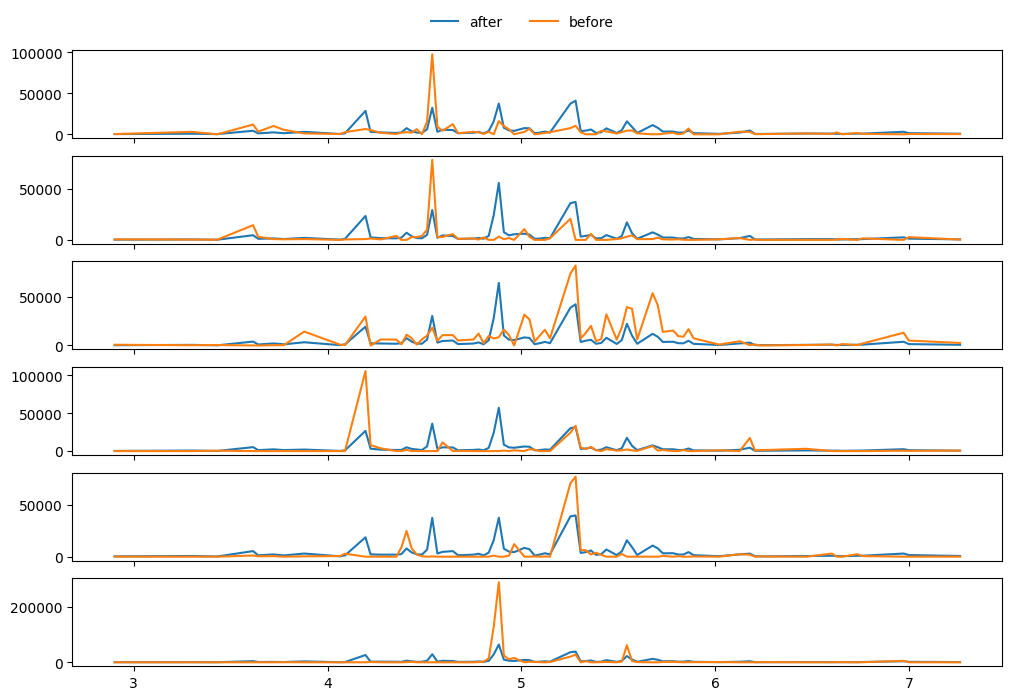

In [39]:
from typing import Sequence
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from scipy.signal._savitzky_golay import savgol_filter

peaks = data[('_SSPVVIDASTAIDAPSNLR_', 3)]['candidate_ms2_metadata']['peaks'][:, :, 1]
rts = data[('_SSPVVIDASTAIDAPSNLR_', 3)]['candidate_ms2_metadata']['rt']

filter_intensity = savgol_filter(peaks, 11, 3, mode='wrap')

ax: Sequence[Axes]
fig, ax = plt.subplots(nrows=filter_intensity.shape[1], ncols=1, figsize=(12, 8), sharex=True)

for i, (before, after) in enumerate(zip(peaks.T, filter_intensity.T)):
    minus_to_zero = np.zeros_like(after)
    indices = np.where(after > 0)

    minus_to_zero[indices] = after[indices]  

    sns.lineplot(x=rts, y=minus_to_zero, ax=ax[i], label='after')
    sns.lineplot(x=rts, y=before, ax=ax[i], label='before')
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].legend().remove()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=2, frameon=False)